In [1]:
import os
# numerical computing package
import numpy as np
# 
from scipy import stats
# command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
# matplotlib
import matplotlib
# find nearest value
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()
#
import sys
#
import pickle
#
import xarray as xr
#
from glob import glob as gb
#
import time
#
import cartopy.crs as ccrs
#
from copy import deepcopy as cp

def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

In [5]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [6]:
!pwd

/home/561/erd561/mom/gfdl_nyf_1080_rcp85


In [7]:
figures_path = '/home/561/erd561/figures/SAMexp/'
script_name = nb_name[:-6]
print('Figures will be saved in: ' + figures_path + script_name + '\n')

nyf_path = '/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/'
ctrl_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
hist5069_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
rcp85_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/'

Figures will be saved in: /home/561/erd561/figures/SAMexp/t14_line_plot



In [8]:
%%time

from dask.distributed import Client
c = Client()
print(c)

<Client: 'tcp://127.0.0.1:36676' processes=4 threads=8, memory=33.67 GB>
CPU times: user 568 ms, sys: 116 ms, total: 684 ms
Wall time: 2.87 s


In [9]:
# ice_daily, ice_month, ocean_bgc_2d, ocean_bgc_carbon, ocean_bgc_daily,
# ocean_bgc_npzd, ocean_cfc, ocean_force, ocean_global, ocean_month, ocean_surface

# nyf_years = np.arange(477, 487)
ctrl_years = np.arange(521, 531)
# hist5069_years = np.arange(501, 576)
rcp85_years = np.arange(596, 606)

# nyf_years_len = len(nyf_years)
ctrl_years_len = len(ctrl_years)
# hist5069_years_len = len(hist5069_years)
rcp85_years_len = len(rcp85_years)

years = np.concatenate([
    np.arange(0, ctrl_years_len+1), 
    np.arange(ctrl_years_len+1, ctrl_years_len + rcp85_years_len)])
print(years)
print(len(years))

# 1. SST
var1 = 'ice_month'
path1 = []

# 2. tx and ty trans
var21 = 'ocean'
var22 = 'ocean_month'
path2 = []

# var31 = 'ocean'
# var32 = 'ocean_month'
# path3 = []

# for y in nyf_years:
#     path1.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
#     path2.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
# #     path3.append(remote_path_ctrl + 'output' + str(y) + '/' + var31 + '.nc')

for y in ctrl_years:
    path1.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')

for y in rcp85_years:
    path1.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')


for p1,p2 in zip(path1,path2):
    print(p1)
    print(p2)
#     print(p3)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
20
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output521/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output521/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output522/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output522/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output523/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output523/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output524/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output524/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output525/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output525/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output526/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/

In [10]:
%%time

lon = [145-360, 165-360]
lat = [-80, -20]

for p1,p2,y in zip(path1, path2, arange(0,20)):
    if p1 == path1[0]:
        tx_trans = \
                xr.open_dataset(p2, decode_times=False).\
                tx_trans.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').assign_coords(year=y)
        
    else:
        tx_trans = \
            xr.concat([
                tx_trans,
                xr.open_dataset(p2, decode_times=False).\
                tx_trans.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').assign_coords(year=y)
            ], 'year'
            )
        
    print(str(p1) + ' OK')

xu_ocean = tx_trans.xu_ocean
xu_ocean_corrected = xu_ocean + 360

tx_trans = tx_trans.assign_coords(xu_ocean=xu_ocean_corrected)

tx_trans = tx_trans.assign_coords(year=years)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output521/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output522/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output523/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output524/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output525/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output526/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output527/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output528/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output529/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output530/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output596/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output597/ocean_month.nc OK
/g/data/e14/

In [11]:
# SST_hist5069 = SST.sel(year=slice(0,9)).mean(dim='year')
# SST_rcp85 = SST.sel(year=slice(10,19)).mean(dim='year')

# pme_river_hist5069 = pme_river.sel(year=slice(0,9)).mean(dim='year')
# pme_river_rcp85 = pme_river.sel(year=slice(10,19)).mean(dim='year')

tx_trans_hist5069 = tx_trans.sel(year=slice(0,9)).mean(dim='year').cumsum('yt_ocean').sum(dim='st_ocean')
tx_trans_rcp85 = tx_trans.sel(year=slice(10,19)).mean(dim='year').cumsum('yt_ocean').sum(dim='st_ocean')

mask = tx_trans.sel(year=0, method='nearest').sel(st_ocean=0, method='nearest')
tx_trans_hist5069 = tx_trans_hist5069.where(np.isfinite(mask), np.nan)
tx_trans_rcp85 = tx_trans_rcp85.where(np.isfinite(mask), np.nan)

# ekman_heat_hist5069 = ekman_heat.sel(year=slice(0,9)).mean(dim='year')/1000
# ekman_heat_rcp85 = ekman_heat.sel(year=slice(10,19)).mean(dim='year')/1000

# u_hist5069 = u.sel(year=slice(0,9)).mean(dim='year')
# u_rcp85 = u.sel(year=slice(10,19)).mean(dim='year')

# v_hist5069 = v.sel(year=slice(0,9)).mean(dim='year')
# v_rcp85 = v.sel(year=slice(10,19)).mean(dim='year')

In [12]:
%%time

lon = [-71, -69]
lat = [-80, -54]

for p1,p2,y in zip(path1, path2, arange(0,20)):
    if p1 == path1[0]:
        tx_trans_DP = \
                xr.open_dataset(p2, decode_times=False).\
                tx_trans.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sum(dim='st_ocean').\
                cumsum('yt_ocean').\
                mean(dim='time').assign_coords(year=y)
        
    else:
        tx_trans_DP = \
            xr.concat([
                tx_trans_DP,
                xr.open_dataset(p2, decode_times=False).\
                tx_trans.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sum(dim='st_ocean').\
                cumsum('yt_ocean').\
                mean(dim='time').assign_coords(year=y)
            ], 'year'
            )
        
    print(str(p1) + ' OK')
    
tx_trans_DP = tx_trans_DP.assign_coords(year=years)

tx_trans_DP_hist5069 = tx_trans_DP.max(dim='yt_ocean').mean(dim='xu_ocean').sel(year=slice(0,9)).mean(dim='year')
tx_trans_DP_rcp85 = tx_trans_DP.max(dim='yt_ocean').mean(dim='xu_ocean').sel(year=slice(10,19)).mean(dim='year')

/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output521/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output522/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output523/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output524/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output525/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output526/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output527/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output528/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output529/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output530/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output596/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output597/ocean_month.nc OK
/g/data/e14/

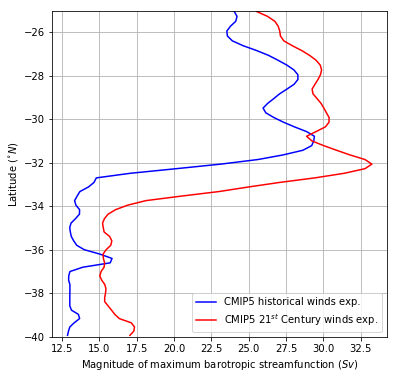

In [14]:
fig = plt.figure() 
fig.set_size_inches(6,6)

matplotlib.rcParams.update({'font.size': 10}) 

anom = -(-tx_trans_hist5069 + tx_trans_DP_hist5069)
plt.plot(anom.sel(yt_ocean=slice(-40,-25)).max('xu_ocean'), 
         anom.sel(yt_ocean=slice(-40,-25)).yt_ocean, 'b')

anom = -(-tx_trans_rcp85 + tx_trans_DP_hist5069)
plt.plot(anom.sel(yt_ocean=slice(-40,-25)).max('xu_ocean'), 
         anom.sel(yt_ocean=slice(-40,-25)).yt_ocean, 'r')

plt.legend(['CMIP5 historical winds exp.', 
            'CMIP5 21$^{st}$ Century winds exp.'])

# plt.title('Maximum southward barotropic transport\nin the Tasman Sea ' + 
#           'between $145^{\circ}E$ and $165^{\circ}E$', loc='left')
plt.xlabel('Magnitude of maximum barotropic streamfunction ($Sv$)')
plt.ylabel('Latitude ($^{\circ}N$)')
plt.ylim([-40, -25])
plt.grid()

output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)
plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig1_.png', bbox_inches='tight', dpi=300)